In [ ]:
# Install required libs
!pip install albumentations  
!pip install segmentation-models-pytorch

In [ ]:
!pip install torchsummary 

In [0]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage

import segmentation_models_pytorch as smp
from torchsummary import summary

from albumentations import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
!cp /content/drive/"My Drive"/segmentation/data.tar.xz /content/
!tar -xf /content/data.tar.xz -C /content/

In [0]:
class SegmentationDataset(Dataset):   
    def __init__(self, image_folder_name, mask_folder_name, augmentation =None, transform = None):
        
        self.image_paths  = np.array(np.sort([image_folder_name + "/" + i for i in os.listdir(image_folder_name)]))
        self.mask_paths  = np.array(np.sort([mask_folder_name + "/"+ i for i in os.listdir(mask_folder_name)]))
        self.transform = transform
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], 0)
        mask = cv2.imread(self.mask_paths[idx], 0)

        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]

        mask[mask != 0] = 255
    
        return self.transform(image), self.transform(mask)
    
    def __len__(self):
        return len(self.image_paths)
        

train_dataset = SegmentationDataset("data/images", 
                                    "data/masks",
                                    augmentation =  Compose([
                                                            ElasticTransform(p=1, alpha=50, sigma=80 * 0.05, alpha_affine=120 * 0.03),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            GridDistortion(p=0.5),
                                                            RandomBrightnessContrast( p=0.5)           
                                                            ]),

                                    transform = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor()
                                                                ])
                                    )

In [22]:
train_batch_size = 3
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle = True)
print(len(train_data_loader))

24


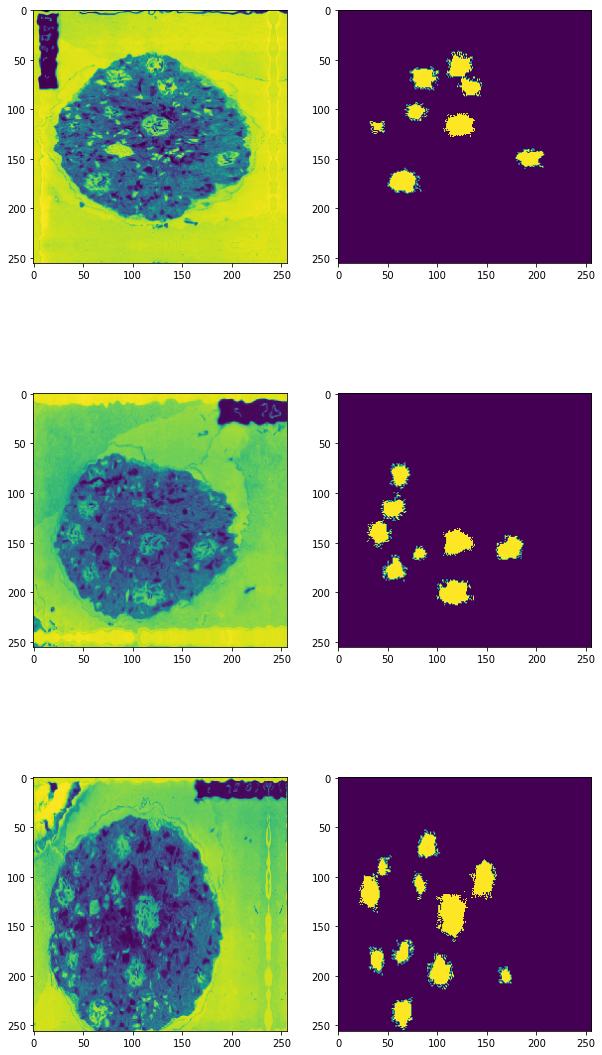

In [8]:
batch  = next(iter(train_data_loader))

images, masks = batch
fig, ax = plt.subplots(train_batch_size, 2, figsize = (10,20))

for i in range(train_batch_size):

    ax[i][0].imshow(images[i][0])
    ax[i][1].imshow(masks[i][0])

In [0]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["nucleus"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 1

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [0]:
train_loader = train_data_loader

In [0]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00015),
])


In [0]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)


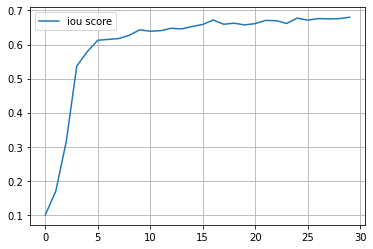

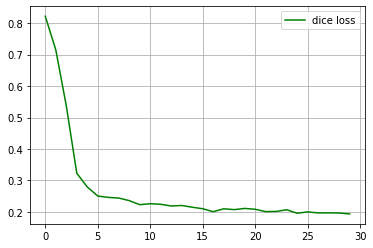

In [27]:

max_score = 0
dice_losses = []
iou_scores  = []
epochs = 30

for i in range(0, epochs):
    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(train_loader)

    dice_losses.append(train_logs["dice_loss"])
    iou_scores.append(train_logs["iou_score"])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    clear_output(wait = True)
    
    plt.plot(iou_scores, label = "iou score")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(dice_losses, color = "green", label = "dice loss")
    plt.legend()
    plt.grid()
    plt.show()

    

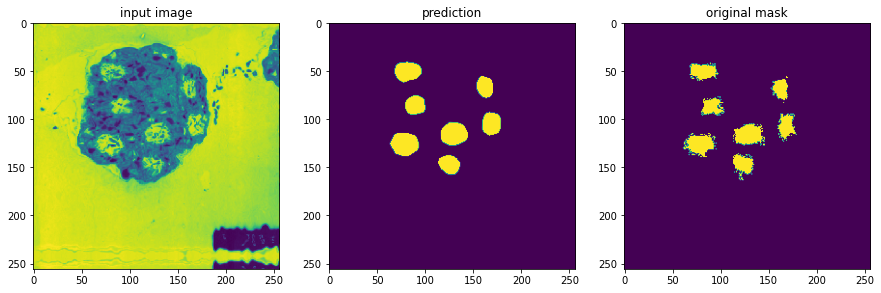

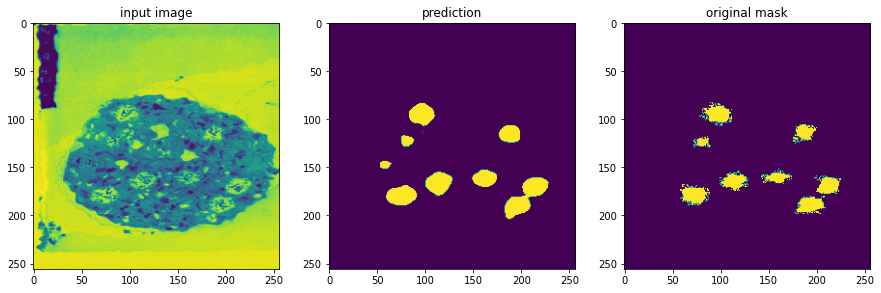

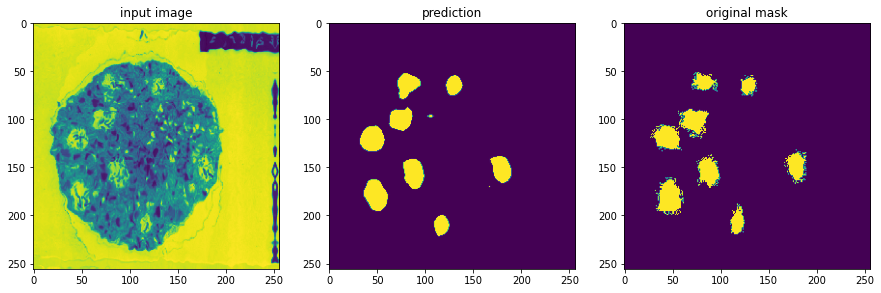

In [20]:
image, masks = next(iter(train_loader))

for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (15,35))

    ax.flat[0].imshow(show_img)
    ax.flat[0].title.set_text('input image')

    ax.flat[1].imshow(show_pred)
    ax.flat[1].title.set_text('prediction')

    ax.flat[2].imshow(show_mask)
    ax.flat[2].title.set_text('original mask')
